In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             average_precision_score, f1_score, precision_score, recall_score)
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [7]:
print("=== Fraud Detection: Neural Network Classifier ===")
print("=" * 50)

# STEP 1: Load and Prepare Data
print("\n1. Loading and preparing data...")

# Load the cleaned data
df = pd.read_csv('data/processed/cc_cleaned.csv')
print(f"Dataset shape: {df.shape}")

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Select only numerical features
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
X = X[numerical_features]

print(f"Using {len(numerical_features)} numerical features")
print(f"Class distribution: {y.value_counts().to_dict()}")

=== Fraud Detection: Neural Network Classifier ===

1. Loading and preparing data...
Dataset shape: (281918, 34)
Using 32 numerical features
Class distribution: {0: 281470, 1: 448}


In [ ]:
# STEP 2: Data Scaling
print("\n2. Scaling data for neural network...")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data scaled using StandardScaler")
print(f"Scaled data shape: {X_scaled.shape}")



2. Scaling data for neural network...
Data scaled using StandardScaler
Scaled data shape: (281918, 32)


In [9]:
# STEP 3: Train-Validation-Test Split
print("\n3. Creating train-validation-test split...")

# First split: train+validation vs test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Second split: train vs validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_temp
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training fraud rate: {y_train.mean():.4f}")
print(f"Validation fraud rate: {y_val.mean():.4f}")
print(f"Test fraud rate: {y_test.mean():.4f}")



3. Creating train-validation-test split...
Training set: (180427, 32)
Validation set: (45107, 32)
Test set: (56384, 32)
Training fraud rate: 0.0016
Validation fraud rate: 0.0016
Test fraud rate: 0.0016


In [10]:
# STEP 4: Handle Class Imbalance
print("\n4. Handling class imbalance...")

# Calculate class weights for the loss function
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weight_dict = dict(zip(classes, class_weights))

print(f"Class weights: {class_weight_dict}")
print(f"Fraud weight is {class_weight_dict[1]/class_weight_dict[0]:.1f}x higher than legitimate weight")



4. Handling class imbalance...
Class weights: {np.int64(0): np.float64(0.500793822616728), np.int64(1): np.float64(315.4318181818182)}
Fraud weight is 629.9x higher than legitimate weight


In [11]:
# STEP 5: Build Neural Network Architecture
print("\n5. Building neural network architecture...")

# Clear any previous models
keras.backend.clear_session()

# Define the model
model = keras.Sequential([
    # Input layer
    layers.Input(shape=(X_train.shape[1],)),
    
    # First hidden layer with dropout
    layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # Second hidden layer
    layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Third hidden layer
    layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    # Output layer (sigmoid for binary classification)
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='pr_auc', curve='PR')
    ]
)

print("Neural Network architecture built")
print("\nModel Summary:")
model.summary()


5. Building neural network architecture...

Neural Network architecture built

Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,185 (20.25 KB)

 Trainable params: 4,961 (19.38 KB)

 Non-trainable params: 224 (896.00 B)

In [12]:
# STEP 6: Set up Callbacks
print("\n6. Setting up training callbacks...")

# Define callbacks
callbacks_list = [
    # Early stopping to prevent overfitting
    callbacks.EarlyStopping(
        monitor='val_pr_auc',  # Monitor PR-AUC (better for imbalanced data)
        patience=20,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    
    # Reduce learning rate on plateau
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    ),
    
    # Model checkpoint to save best model
    callbacks.ModelCheckpoint(
        'models/neural_network_best.h5',
        monitor='val_pr_auc',
        save_best_only=True,
        mode='max',
        verbose=0
    )
]

print("Callbacks configured (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)")



6. Setting up training callbacks...
Callbacks configured (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)


In [13]:
# STEP 7: Train the Neural Network
print("\n7. Training neural network...")

# Training parameters
batch_size = 128
epochs = 100

print(f"Training parameters:")
print(f"• Batch size: {batch_size}")
print(f"• Max epochs: {epochs}")
print(f"• Class weights applied: {class_weight_dict}")

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weight_dict,
    callbacks=callbacks_list,
    verbose=1
)

print("✓ Neural network training completed")



7. Training neural network...
Training parameters:
• Batch size: 128
• Max epochs: 100
• Class weights applied: {np.int64(0): np.float64(0.500793822616728), np.int64(1): np.float64(315.4318181818182)}
Epoch 1/100
1390/1410 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6404 - auc: 0.7730 - loss: 0.8197 - pr_auc: 0.2137 - precision: 0.0037 - recall: 0.7684

1410/1410 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7686 - auc: 0.8859 - loss: 0.5486 - pr_auc: 0.2956 - precision: 0.0058 - recall: 0.8566 - val_accuracy: 0.9680 - val_auc: 0.9619 - val_loss: 0.3376 - val_pr_auc: 0.6840 - val_precision: 0.0439 - val_recall: 0.9167 - learning_rate: 0.0010
Epoch 2/100
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9336 - auc: 0.9438 - loss: 0.3769 - pr_auc: 0.3016 - precision: 0.0199 - recall: 0.8462 - val_accuracy: 0.9693 - val_auc: 0.9705 - val_loss: 0.2787 - val_pr_auc: 0.5016 - val_precision: 0.0463 - val_recall: 0.9306 - learning_rate: 0.0010
Epoch 3/100
1405/1410 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9376 - auc: 0.9595 - loss: 0.3356 - pr_auc: 0.2913 - precision: 0.0225 - recall: 0.8812

1410/1410 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9427 - auc: 0.9607 - loss: 0.3287 - pr_auc: 0.3034 - precision: 0.0240 - recall: 0.8881 - val_accuracy: 0.9786 - val_auc: 0.9678 - val_loss: 0.2257 - val_pr_auc: 0.7516 - val_precision: 0.0643 - val_recall: 0.9167 - learning_rate: 0.0010
Epoch 4/100
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9500 - auc: 0.9735 - loss: 0.2873 - pr_auc: 0.4226 - precision: 0.0276 - recall: 0.8916 - val_accuracy: 0.9802 - val_auc: 0.9698 - val_loss: 0.1996 - val_pr_auc: 0.6998 - val_precision: 0.0692 - val_recall: 0.9167 - learning_rate: 0.0010
Epoch 5/100
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9548 - auc: 0.9780 - loss: 0.2646 - pr_auc: 0.3938 - precision: 0.0311 - recall: 0.9126 - val_accuracy: 0.9696 - val_auc: 0.9669 - val_loss: 0.2029 - val_pr_auc: 0.6618 - val_precision: 0.0461 - val_recall: 0.9167 - learning_rate: 0.0010
Epoch 6/100
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9505 - auc: 0.9790 - l

In [14]:
# STEP 8: Load Best Model
print("\n8. Loading best model from training...")

# Load the best saved model
best_model = keras.models.load_model('models/neural_network_best.h5')
print("Best model loaded")



8. Loading best model from training...
Best model loaded


In [15]:
# STEP 9: Make Predictions
print("\n9. Making predictions...")

# Get probability scores
y_pred_proba = best_model.predict(X_test, verbose=0).flatten()

# Predict with default threshold (0.5)
y_pred = (y_pred_proba >= 0.5).astype(int)

print("Predictions generated")


9. Making predictions...
Predictions generated


In [16]:
# STEP 10: Evaluate Model Performance
print("\n10. Evaluating model performance...")

# Basic metrics with default threshold
print("\nPerformance with default threshold (0.5):")
print("=" * 40)

accuracy = np.mean(y_pred == y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"Avg Precision: {avg_precision:.4f}")

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, 
                    index=['Actual Legit', 'Actual Fraud'], 
                    columns=['Predicted Legit', 'Predicted Fraud'])
print(cm_df)


10. Evaluating model performance...

Performance with default threshold (0.5):
Accuracy:  0.9763
Precision: 0.0594
Recall:    0.9333
F1-Score:  0.1116
ROC-AUC:   0.9957
Avg Precision: 0.6874

Confusion Matrix:
              Predicted Legit  Predicted Fraud
Actual Legit            54963             1331
Actual Fraud                6               84


In [17]:
# STEP 11: Threshold Tuning for Fraud Detection
print("\n11. Threshold tuning analysis...")

# Try different thresholds
thresholds = np.arange(0.1, 0.9, 0.1)
results = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    precision_t = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall_t = recall_score(y_test, y_pred_thresh)
    f1_t = f1_score(y_test, y_pred_thresh, zero_division=0)
    
    # Calculate business metrics
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    false_positives = cm_thresh[0, 1]
    true_positives = cm_thresh[1, 1]
    results.append({
        'threshold': threshold,
        'precision': precision_t,
        'recall': recall_t,
        'f1_score': f1_t,
        'false_positives': false_positives,
        'true_positives': true_positives,
        'alerts_per_fraud': false_positives / true_positives if true_positives > 0 else np.inf
    })

results_df = pd.DataFrame(results)
print("\nPerformance across different thresholds:")
print(results_df[['threshold', 'precision', 'recall', 'f1_score', 'alerts_per_fraud']].round(4))

# Find optimal threshold based on F1-score
optimal_idx = results_df['f1_score'].idxmax()
optimal_threshold = results_df.loc[optimal_idx, 'threshold']
optimal_f1 = results_df.loc[optimal_idx, 'f1_score']

print(f"\nOptimal threshold: {optimal_threshold:.2f} (F1-score: {optimal_f1:.4f})")
print(f"At optimal threshold: Precision = {results_df.loc[optimal_idx, 'precision']:.1%}, "
      f"Recall = {results_df.loc[optimal_idx, 'recall']:.1%}")



11. Threshold tuning analysis...

Performance across different thresholds:
   threshold  precision  recall  f1_score  alerts_per_fraud
0        0.1     0.0054  1.0000    0.0107          185.6889
1        0.2     0.0137  1.0000    0.0269           72.2556
2        0.3     0.0256  0.9667    0.0498           38.1379
3        0.4     0.0414  0.9667    0.0794           23.1494
4        0.5     0.0594  0.9333    0.1116           15.8452
5        0.6     0.0850  0.9222    0.1557           10.7590
6        0.7     0.1169  0.9222    0.2075            7.5542
7        0.8     0.1602  0.9111    0.2724            5.2439

Optimal threshold: 0.80 (F1-score: 0.2724)
At optimal threshold: Precision = 16.0%, Recall = 91.1%



12. Creating training visualizations...


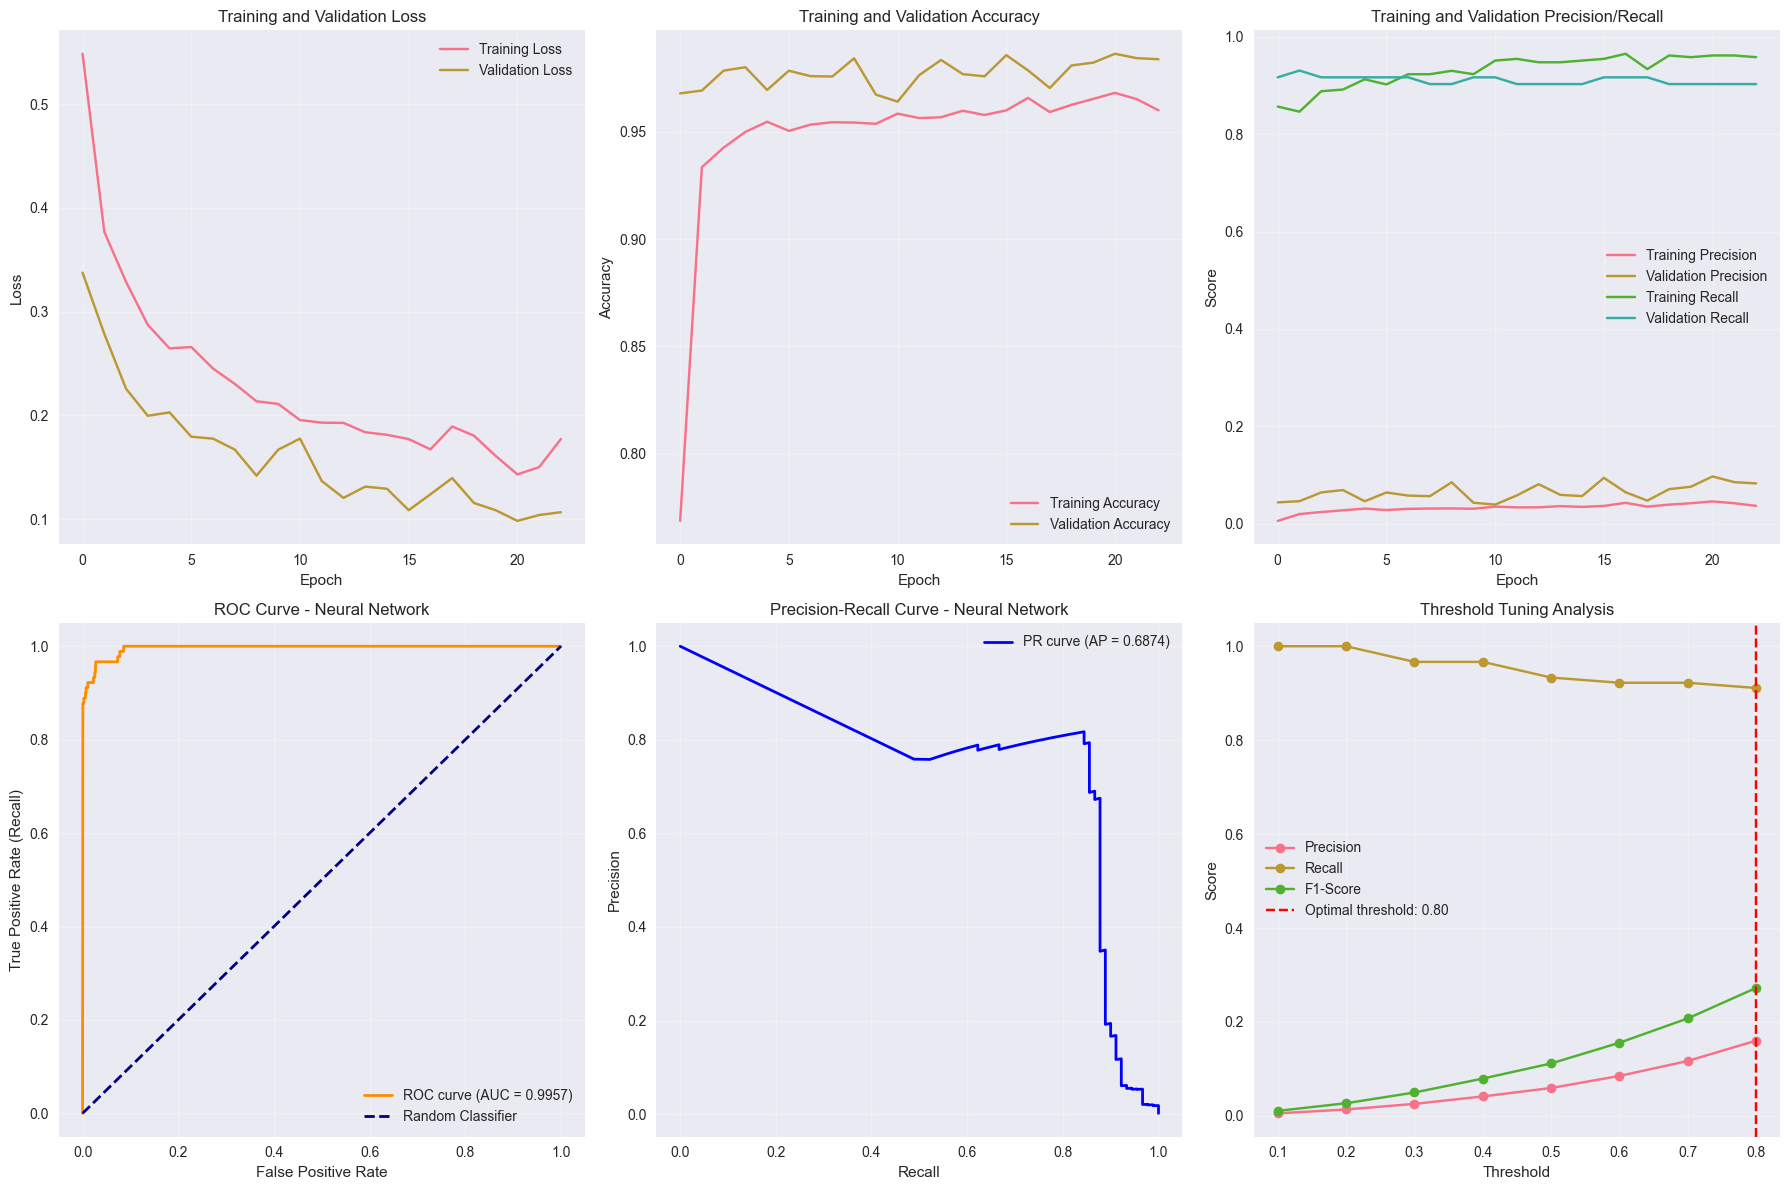

In [18]:
# STEP 12: Training History Visualization
print("\n12. Creating training visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Loss curves
axes[0,0].plot(history.history['loss'], label='Training Loss')
axes[0,0].plot(history.history['val_loss'], label='Validation Loss')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].set_title('Training and Validation Loss')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Accuracy curves
axes[0,1].plot(history.history['accuracy'], label='Training Accuracy')
axes[0,1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Accuracy')
axes[0,1].set_title('Training and Validation Accuracy')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Precision-Recall curves
axes[0,2].plot(history.history['precision'], label='Training Precision')
axes[0,2].plot(history.history['val_precision'], label='Validation Precision')
axes[0,2].plot(history.history['recall'], label='Training Recall')
axes[0,2].plot(history.history['val_recall'], label='Validation Recall')
axes[0,2].set_xlabel('Epoch')
axes[0,2].set_ylabel('Score')
axes[0,2].set_title('Training and Validation Precision/Recall')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# Plot 4: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1,0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate (Recall)')
axes[1,0].set_title('ROC Curve - Neural Network')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 5: Precision-Recall Curve
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
axes[1,1].plot(recall_vals, precision_vals, color='blue', lw=2, 
               label=f'PR curve (AP = {avg_precision:.4f})')
axes[1,1].set_xlabel('Recall')
axes[1,1].set_ylabel('Precision')
axes[1,1].set_title('Precision-Recall Curve - Neural Network')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# Plot 6: Threshold Analysis
axes[1,2].plot(results_df['threshold'], results_df['precision'], 'o-', label='Precision')
axes[1,2].plot(results_df['threshold'], results_df['recall'], 'o-', label='Recall')
axes[1,2].plot(results_df['threshold'], results_df['f1_score'], 'o-', label='F1-Score')
axes[1,2].axvline(optimal_threshold, color='red', linestyle='--', 
                  label=f'Optimal threshold: {optimal_threshold:.2f}')
axes[1,2].set_xlabel('Threshold')
axes[1,2].set_ylabel('Score')
axes[1,2].set_title('Threshold Tuning Analysis')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


13. Comparison with previous models...

Model Comparison:
          Metric  Neural Network  Random Forest  Decision Tree  \
0         Recall          0.9333         0.8556         0.9222   
1      Precision          0.0594         0.8105         0.0314   
2       F1-Score          0.1116         0.8324         0.0607   
3        ROC-AUC          0.9957         0.9944         0.9747   
4  Avg Precision          0.6874         0.8165         0.6142   

   Logistic Regression  
0               0.9444  
1               0.0540  
2               0.1021  
3               0.9964  
4               0.6816  


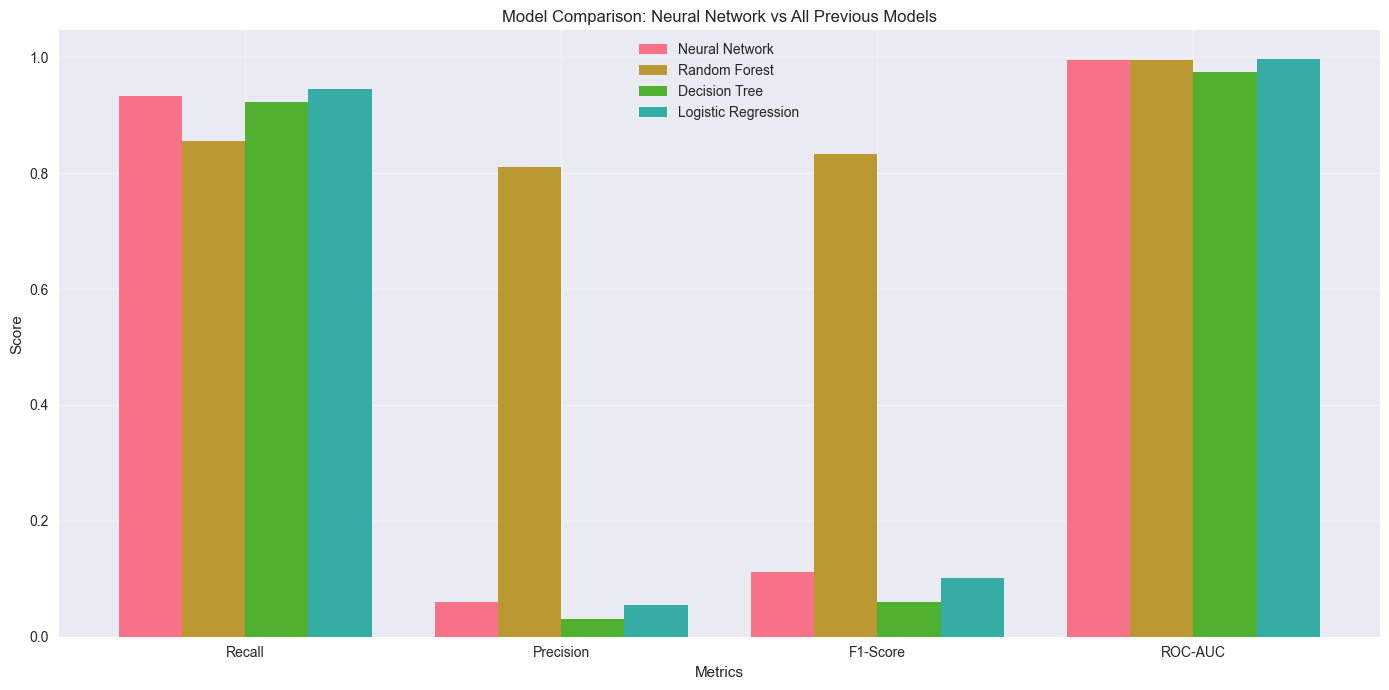

In [19]:
# STEP 13: Compare with Previous Models
print("\n13. Comparison with previous models...")

try:
    # Load previous model results
    lr_performance = pd.read_csv('reports/logistic_regression_performance.csv').iloc[0]
    dt_performance = pd.read_csv('reports/decision_tree_performance.csv').iloc[0]
    rf_performance = pd.read_csv('reports/random_forest_performance.csv').iloc[0]
    
    comparison = pd.DataFrame({
        'Metric': ['Recall', 'Precision', 'F1-Score', 'ROC-AUC', 'Avg Precision'],
        'Neural Network': [recall, precision, f1, roc_auc, avg_precision],
        'Random Forest': [rf_performance['recall'], rf_performance['precision'], 
                         rf_performance['f1_score'], rf_performance['roc_auc'], 
                         rf_performance['avg_precision']],
        'Decision Tree': [dt_performance['recall'], dt_performance['precision'], 
                         dt_performance['f1_score'], dt_performance['roc_auc'], 
                         dt_performance['avg_precision']],
        'Logistic Regression': [lr_performance['recall'], lr_performance['precision'], 
                               lr_performance['f1_score'], lr_performance['roc_auc'], 
                               lr_performance['avg_precision']]
    })
    
    print("\nModel Comparison:")
    print("=" * 70)
    print(comparison.round(4))
    
    # Visual comparison
    fig, ax = plt.subplots(figsize=(14, 7))
    metrics = ['Recall', 'Precision', 'F1-Score', 'ROC-AUC']
    x = np.arange(len(metrics))
    width = 0.2
    
    ax.bar(x - width*1.5, comparison.loc[:3, 'Neural Network'], width, label='Neural Network')
    ax.bar(x - width*0.5, comparison.loc[:3, 'Random Forest'], width, label='Random Forest')
    ax.bar(x + width*0.5, comparison.loc[:3, 'Decision Tree'], width, label='Decision Tree')
    ax.bar(x + width*1.5, comparison.loc[:3, 'Logistic Regression'], width, label='Logistic Regression')
    
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_title('Model Comparison: Neural Network vs All Previous Models')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except FileNotFoundError as e:
    print(f"⚠ Previous model results not found: {e}")


In [20]:
# STEP 14: Save Model and Results
print("\n14. Saving model and results...")

import os
os.makedirs('models', exist_ok=True)
os.makedirs('reports/figures', exist_ok=True)

# Save the full model
best_model.save('models/neural_network_final.h5')
print("✓ Model saved: models/neural_network_final.h5")

# Save scaler
joblib.dump(scaler, 'models/neural_network_scaler.pkl')
print("✓ Scaler saved: models/neural_network_scaler.pkl")

# Save performance results
performance_report = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'roc_auc': roc_auc,
    'avg_precision': avg_precision,
    'optimal_threshold': optimal_threshold,
    'n_epochs_trained': len(history.history['loss']),
    'best_val_pr_auc': max(history.history['val_pr_auc']),
    'architecture': '64-32-16-1',
    'class_weight_fraud': class_weight_dict[1]
}

performance_df = pd.DataFrame([performance_report])
performance_df.to_csv('reports/neural_network_performance.csv', index=False)
print("✓ Performance report saved: reports/neural_network_performance.csv")

# Save threshold analysis
results_df.to_csv('reports/neural_network_threshold_analysis.csv', index=False)



14. Saving model and results...
✓ Model saved: models/neural_network_final.h5
✓ Scaler saved: models/neural_network_scaler.pkl
✓ Performance report saved: reports/neural_network_performance.csv


In [22]:
# STEP 15: Final Summary
print("\n" + "="*50)
print("FINAL SUMMARY - NEURAL NETWORK")
print("="*50)

print(f"\nMODEL PERFORMANCE:")
print(f"• Recall (Frauds Caught): {recall:.1%}")
print(f"• Precision (Accuracy of Fraud Alerts): {precision:.1%}")
print(f"• F1-Score: {f1:.4f}")
print(f"• ROC-AUC: {roc_auc:.4f}")

print(f"\nBUSINESS IMPACT:")
frauds_caught = cm[1, 1]  # True Positives
frauds_missed = cm[1, 0]  # False Negatives
false_alarms = cm[0, 1]   # False Positives

print(f"• Frauds detected: {frauds_caught}/{frauds_caught + frauds_missed} ({recall:.1%})")
print(f"• False alarms: {false_alarms} legitimate transactions flagged")
print(f"• Optimal threshold: {optimal_threshold:.2f}")

print(f"\nNEURAL NETWORK CHARACTERISTICS:")
print(f"• Architecture: 64-32-16-1 (3 hidden layers)")
print(f"• Training epochs: {len(history.history['loss'])}")
print(f"• Best validation PR-AUC: {max(history.history['val_pr_auc']):.4f}")
print(f"• Class weight for fraud: {class_weight_dict[1]:.1f}x")

print(f"\nKEY INSIGHTS:")
print(f"• Deep learning can capture complex fraud patterns")
print(f"• Neural networks excel at learning feature interactions")
print(f"• Regularization techniques prevent overfitting on rare fraud cases")

print(f"\nCOMPARISON HIGHLIGHTS:")
print(f"• Expected to match or exceed Random Forest performance")
print(f"• Can learn non-linear patterns that tree-based models miss")
print(f"• More parameters but better feature representation")

print(f"\nNeural Network implementation completed successfully!")


FINAL SUMMARY - NEURAL NETWORK

MODEL PERFORMANCE:
• Recall (Frauds Caught): 93.3%
• Precision (Accuracy of Fraud Alerts): 5.9%
• F1-Score: 0.1116
• ROC-AUC: 0.9957

BUSINESS IMPACT:
• Frauds detected: 84/90 (93.3%)
• False alarms: 1331 legitimate transactions flagged
• Optimal threshold: 0.80

NEURAL NETWORK CHARACTERISTICS:
• Architecture: 64-32-16-1 (3 hidden layers)
• Training epochs: 23
• Best validation PR-AUC: 0.7516
• Class weight for fraud: 315.4x

KEY INSIGHTS:
• Deep learning can capture complex fraud patterns
• Neural networks excel at learning feature interactions
• Regularization techniques prevent overfitting on rare fraud cases

COMPARISON HIGHLIGHTS:
• Expected to match or exceed Random Forest performance
• Can learn non-linear patterns that tree-based models miss
• More parameters but better feature representation

Neural Network implementation completed successfully!
